In [1]:
import os
import random

import matplotlib.pyplot as plt
import PIL
import torch

import pandas as pd

/opt/homebrew/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train_info = pd.read_csv('datasets/train.csv', index_col='image_id')
train_info.head()

label
image_id                                                        
46514481-2d8b-4d49-8991-012e1bfd34f6.jpeg               swimming
ec66e513-adac-4a30-b6a9-3d647ee6e46b.jpeg  greco-Roman_wrestling
4d60732e-d680-4bfd-9067-70ff8137f537.jpeg                running
93327011-8e3d-4f0d-849d-a26ddaf6488b.jpeg               football
b6853478-48c1-48b2-b104-74903730c831.jpeg                sailing

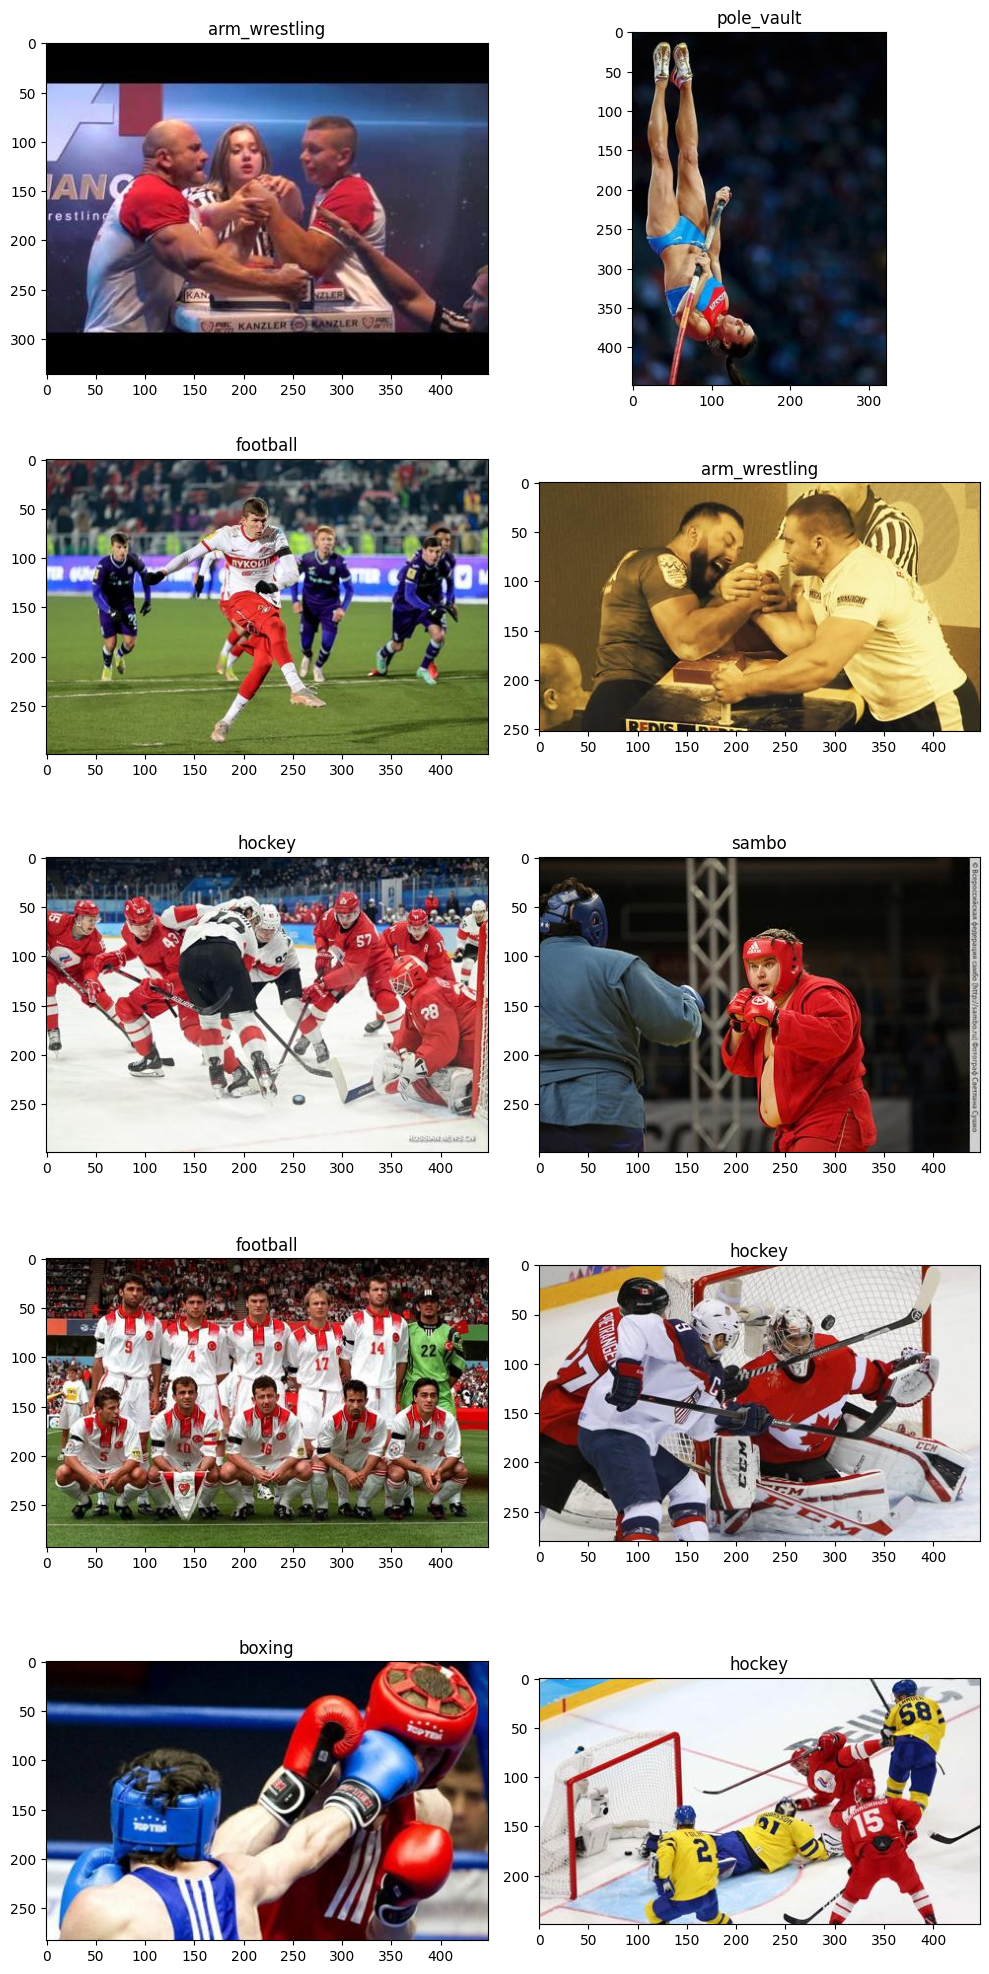

In [3]:
path_to_data = 'datasets/train'

data = os.listdir(path_to_data)
data_sample = random.choices(data, k=10)
plt.figure(figsize=(10, 20))
for plot_number, path in enumerate(data_sample):
    with PIL.Image.open(f'{path_to_data}/{path}') as img:
        img.load()
    plt.subplot(5, 2, plot_number + 1)
    plt.title(train_info.loc[path, 'label'])
    plt.imshow(img)
    
plt.tight_layout()
plt.show()

Сразу же видно, что есть фотографии ошибочно размеченные. Изучим какие виды спорта представлены в датасете.

In [4]:
train_info['label'].unique()

array(['swimming', 'greco-Roman_wrestling', 'running', 'football',
       'sailing', 'basketball', 'fencing', 'surfing', 'alpinism', 'golf',
       'water_polo', 'rugby', 'horseback_riding', 'sambo', 'hockey',
       'taekwondo', 'skating', 'boating', 'ski_race', 'tennis', 'velo',
       'handball', 'arm_wrestling', 'archery', 'pole_vault', 'boxing',
       'volleyball', 'gymnastics', 'javelin-throwing', 'badminton'],
      dtype=object)

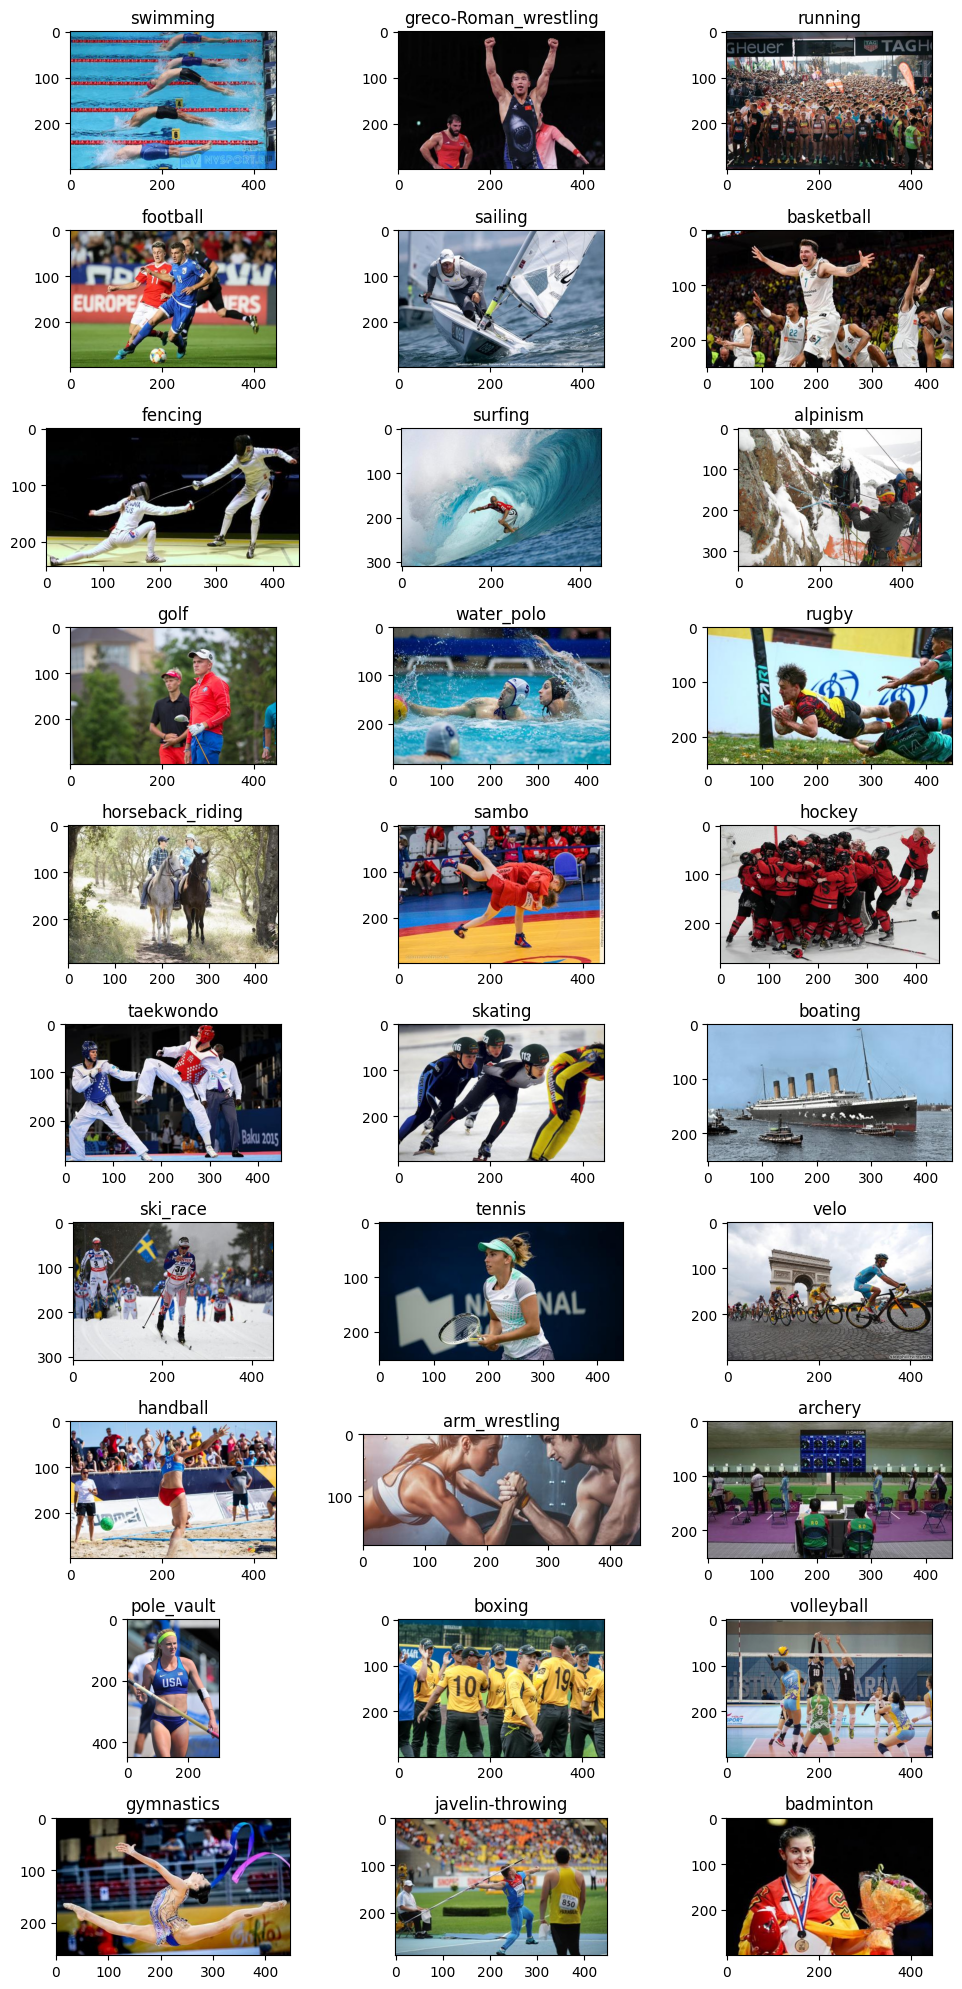

In [5]:
path_to_data = 'datasets/train'

data = os.listdir(path_to_data)
plt.figure(figsize=(10, 20))
for plot_number, name in enumerate(train_info['label'].unique()):
    path = random.choice(train_info[train_info['label']==name].index)
    with PIL.Image.open(f'{path_to_data}/{path}') as img:
        img.load()
    plt.subplot(10, 3, plot_number + 1)
    plt.title(train_info.loc[path, 'label'])
    plt.imshow(img)
    
plt.tight_layout()
plt.show()

Часто бокс оказывает ошибочно размеченным. Изучим несколько примеров отдельно.

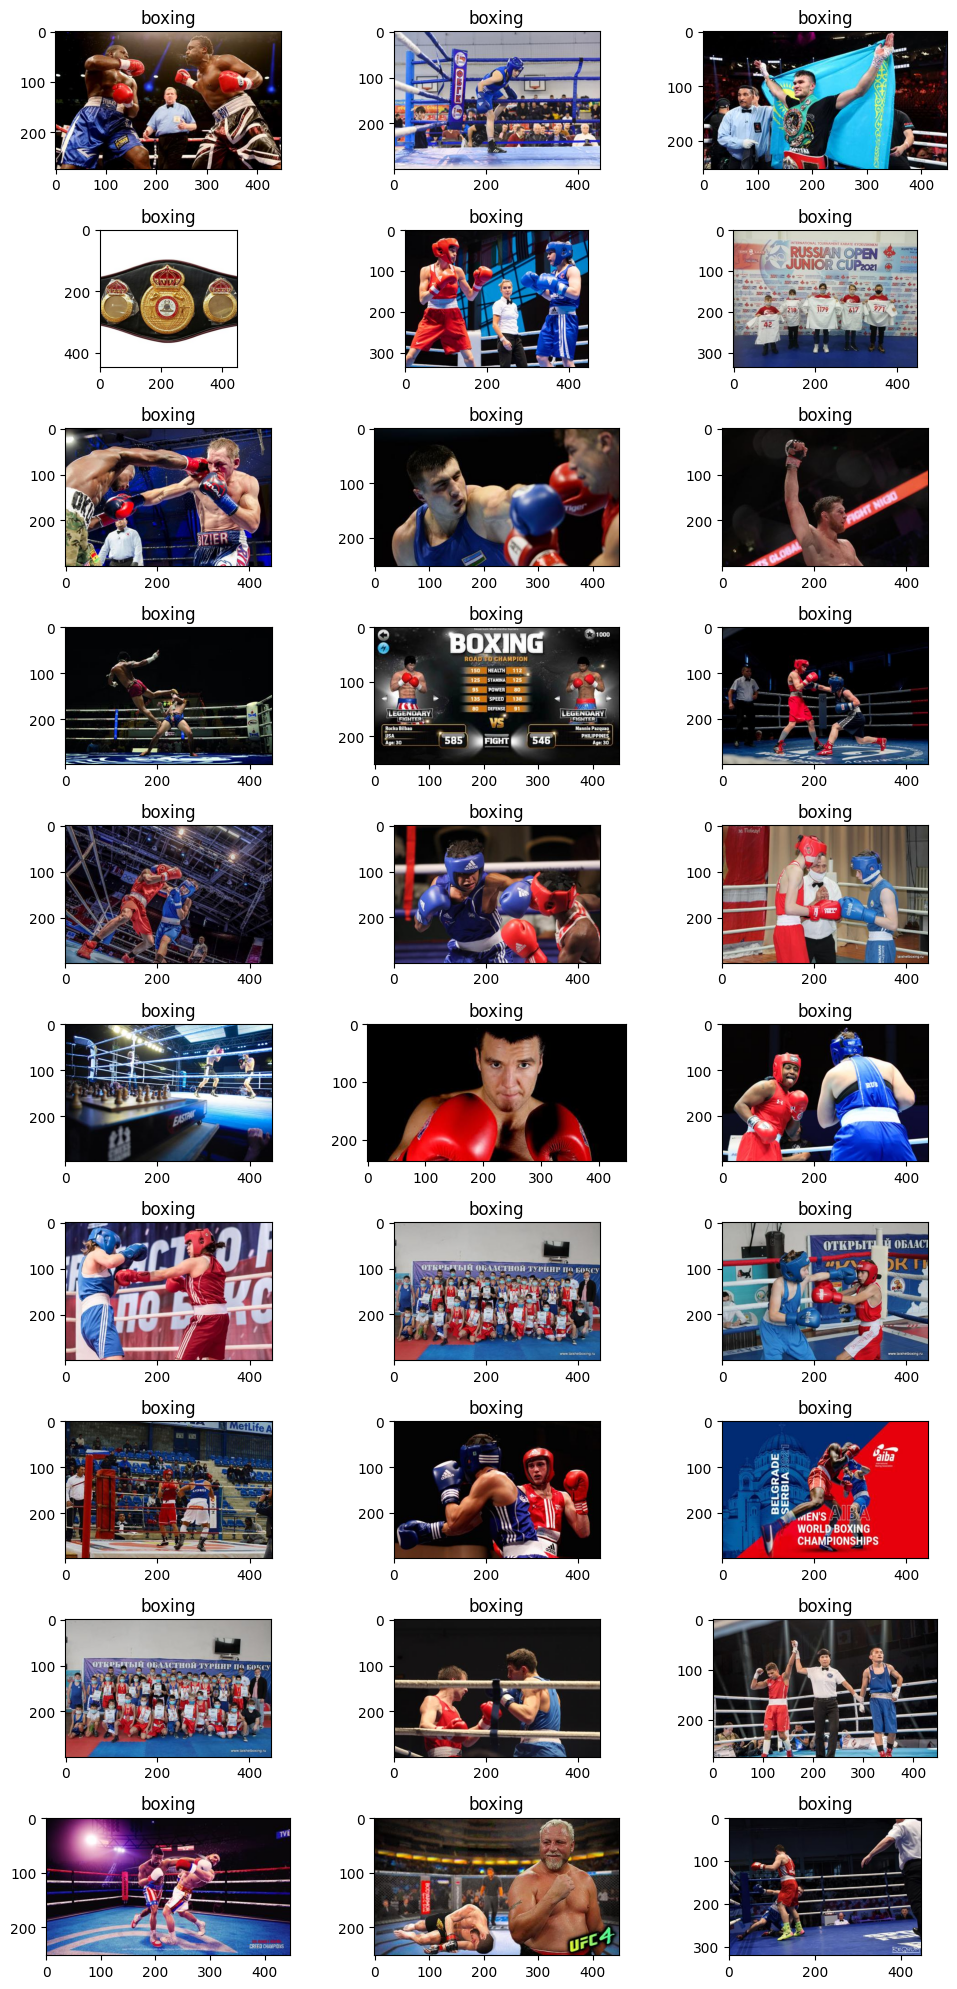

In [6]:
path_to_data = 'datasets/train'

data = os.listdir(path_to_data)
plt.figure(figsize=(10, 20))
for plot_number in range(30):
    path = random.choice(train_info[train_info['label']=='boxing'].index)
    with PIL.Image.open(f'{path_to_data}/{path}') as img:
        img.load()
    plt.subplot(10, 3, plot_number + 1)
    plt.title(train_info.loc[path, 'label'])
    plt.imshow(img)
    
plt.tight_layout()
plt.show()

Загрузка модели ViT

Выделение фичей с помощью ViT

In [7]:
from transformers import ViTFeatureExtractor

model_name_or_path = 'google/vit-base-patch16-224-in21k'
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name_or_path)

In [8]:
from sklearn.preprocessing import LabelEncoder


def load_dataset(path_to_data, path_to_labels):
    dataset = []
    dataset_meta = pd.read_csv(path_to_labels, index_col='image_id')
    encoder = LabelEncoder()
    dataset_meta['label'] = encoder.fit_transform(dataset_meta['label'])
    data = os.listdir(path_to_data)
    for path in data[:5000]:
        with PIL.Image.open(f'{path_to_data}/{path}').convert('RGB') as img:
            img.load()
        label = dataset_meta.loc[path, 'label']
        dataset.append({
            'image': img,
            'label': label
        })
    return dataset, encoder

def transform(example_batch):
    # Take a list of PIL images and turn them to pixel values
    inputs = feature_extractor([x['image'] for x in example_batch], return_tensors='pt')

    # Don't forget to include the labels!
    inputs['labels'] = [x['label'] for x in example_batch]
    return inputs

path_to_data = 'datasets/train'
path_to_labels = 'datasets/train.csv'
ds, encoder = load_dataset(path_to_data, path_to_labels)
ds = ds[:5000]

In [9]:
def transform(example_batch):
    transformed = []
    for x in example_batch:
        transformed.append(process_example(x))
    return transformed

def process_example(example):
    inputs = feature_extractor(example['image'], return_tensors='pt')
    inputs['pixel_values'] = inputs['pixel_values'].squeeze(0)
    inputs['labels'] = example['label']
    return inputs

def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['labels'] for x in batch])
    }

In [10]:
processed_ds = transform(ds)
del ds

In [11]:
from transformers import ViTForImageClassification
from transformers import TrainingArguments
from transformers import Trainer

labels = encoder.classes_

model = ViTForImageClassification.from_pretrained(
    model_name_or_path,
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)}
)


Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
import numpy as np
from datasets import load_metric

metric = load_metric("accuracy")
def compute_metrics(p):
    return metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)

/var/folders/46/9pmddt197tg1cz85qrsc593w0000gn/T/ipykernel_1655/2425197347.py:4: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


In [13]:
training_args = TrainingArguments(
  output_dir="./vit-base-beans",
  per_device_train_batch_size=64,
  evaluation_strategy="steps",
  num_train_epochs=4,
  fp16=False,  # change for GPU
  save_steps=100,
  eval_steps=100,
  logging_steps=10,
  learning_rate=2e-4,
  save_total_limit=2,
  remove_unused_columns=False,
  push_to_hub=False,
  report_to='tensorboard',
  load_best_model_at_end=True,
)


In [14]:
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=processed_ds[:4500],
    eval_dataset=processed_ds[500:],
    tokenizer=feature_extractor,
)


In [15]:
train_results = trainer.train()
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()


/opt/homebrew/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 4500
  Num Epochs = 4
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 284
  Number of trainable parameters = 85821726


***** Running Evaluation *****
  Num examples = 4500
  Batch size = 8
Saving model checkpoint to ./vit-base-beans/checkpoint-100
Configuration saved in ./vit-base-beans/checkpoint-100/config.json
Model weights saved in ./vit-base-beans/checkpoint-100/pytorch_model.bin
Image processor saved in ./vit-base-beans/checkpoint-100/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 4500
  Batch size = 8
Saving model checkpoint to ./vit-base-beans/checkpoint-200
Configuration saved in ./vit-base-beans/checkpoint-200/config.json
Model weights saved in ./vit-base-beans/checkpoint-200/pytorch_model.bin
Image processor saved in ./vit-base-beans/checkpoint-200/preprocessor_config.json


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./vit-base-beans/checkpoint-200 (score: 0.26583799719810486).
Saving model checkpoint to ./vit-base-beans
Configuration saved in ./vit-base-beans/config.json
Model weights saved in ./vit-b

***** train metrics *****
  epoch                    =          4.0
  total_flos               = 1299386713GF
  train_loss               =       0.8073
  train_runtime            =   1:58:35.78
  train_samples_per_second =         2.53
  train_steps_per_second   =         0.04


{'image': <PIL.Image.Image image mode=RGB size=448x253>, 'label': 1}

In [147]:
processed_ds[]

{'pixel_values': tensor([[[-0.9137, -0.9137, -0.9137,  ..., -0.8510, -0.8510, -0.8510],
         [-0.9137, -0.9137, -0.9137,  ..., -0.8588, -0.8588, -0.8588],
         [-0.9137, -0.9137, -0.9137,  ..., -0.8588, -0.8588, -0.8588],
         ...,
         [-0.8745, -0.8824, -0.8824,  ..., -0.8902, -0.8902, -0.8902],
         [-0.8824, -0.8824, -0.8824,  ..., -0.8902, -0.8902, -0.8902],
         [-0.8824, -0.8824, -0.8824,  ..., -0.8902, -0.8902, -0.8902]],

        [[-0.0431, -0.0431, -0.0431,  ..., -0.0510, -0.0510, -0.0510],
         [-0.0431, -0.0431, -0.0431,  ..., -0.0588, -0.0588, -0.0588],
         [-0.0431, -0.0431, -0.0431,  ..., -0.0588, -0.0588, -0.0588],
         ...,
         [-0.0745, -0.0824, -0.0824,  ..., -0.1137, -0.1137, -0.1137],
         [-0.0824, -0.0824, -0.0824,  ..., -0.1137, -0.1137, -0.1137],
         [-0.0824, -0.0824, -0.0824,  ..., -0.1137, -0.1137, -0.1137]],

        [[-0.3804, -0.3804, -0.3804,  ..., -0.4196, -0.4196, -0.4196],
         [-0.3804, -0.3804, 

In [165]:
logits = trainer.model(processed_ds[1]['pixel_values'].unsqueeze(0)).logits

In [189]:
from torch.nn.functional import softmax


def decode_prediction(example, model):
    pixels = example['pixel_values'].unsqueeze(0)
    preds = model(pixels).logits
    preds = torch.argmax(softmax(preds, dim=1))
    return preds

In [193]:
decode_prediction(processed_ds[2], trainer.model)

tensor(5)

In [ ]:
from torch.nn.functional import softmax

def process_test_dataset(path_to_test, path_to_test_meta, model):
    test_meta = pd.read_csv('datasets/test.csv')
    test_predictions = []
    for path in test_meta['image_id']:
        with PIL.Image.open(r'datasets/test/' + path).convert('RGB') as img:
            img.load()
            pixels = feature_extractor(img, return_tensors='pt')
            pixels = pixels['pixel_values']
            preds = model(pixels).logits
            preds = torch.argmax(softmax(preds, dim=1))
            test_predictions.append(preds.item())
    return pd.DataFrame({'preds': test_predictions})

test_prediction = process_test_dataset('datasets/test', 'datasets/test.csv', trainer.model)

In [22]:
test_prediction

preds
0     22
1      4
2      0
3     26
4      7

In [24]:
test_prediction['preds'] = encoder.inverse_transform(test_prediction['preds'])

/opt/homebrew/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array(['ski_race', 'basketball', 'alpinism', 'tennis', 'fencing'],
      dtype=object)

In [ ]:
encoder.inverse_transform(test_prediction['preds'])